# Load

## Libs

In [1]:
suppressPackageStartupMessages({
    source('../libs.R')
    source('../utils.R')    
    source('../Figures/colors.R')    
    source('../utils_mapping.R')
    source('../utils_plotting.R')
})


## All cells

In [2]:
# obj <- readRDS('/data/srlab2/ik936/Roche/data/cache/all_obj_all.rds')

In [3]:
dname <- '/data/srlab2/ik936/Roche/data/cache/all_obj_all/'
fields_load <- c('meta_data', 'umap_before', 'clusters_df', 'exprs_norm')
obj <- map(fields_load, function(name) {
    readRDS(file.path(dname, paste0(name, '.rds')))
})
names(obj) <- fields_load


In [4]:
Clusters <- obj$clusters_df[, 1]
obj$meta_data$Lineage <- case_when(
    Clusters %in% c('5', '6', '0') ~ 'Fibroblast',
    Clusters %in% c('10') ~ 'Mural',
    Clusters %in% c('12', '7', '8') ~ 'Epithelial',
    Clusters %in% c('13') ~ 'Glial',
    Clusters %in% c('3', '4') ~ 'Endothelial',
    Clusters %in% c('9') ~ 'Plasma',
    Clusters %in% c('1', '2', '11') ~ 'Leukocyte'   
) 


## fibs

In [5]:
fib <- list()
fib$synovium <- readRDS('/data/srlab2/ik936/Roche/data/cache/synovium_fibroblasts_obj.rds')
fib$lung <- readRDS('/data/srlab2/ik936/Roche/data/cache/lung_fibroblasts_obj.rds')
fib$salivarygland <- readRDS('/data/srlab2/ik936/Roche/data/cache/salivarygland_fibroblasts_obj.rds')
fib$gut <- readRDS('/data/srlab2/ik936/Roche/data/cache/fibroblast_object_gut.rds')


fib$synovium$meta_data <- fib$synovium$meta_data %>% 
    dplyr::mutate(tissue_cell_type = case_when(
        tissue_cell_type == 'NOTCH3+ perivascular' ~ 'Sublining',
        TRUE ~ tissue_cell_type
    ))


In [6]:
dname <- '/data/srlab2/ik936/Roche/data/cache/obj_fibroblasts/'
fields_load <- c('meta_data', 'effects_marginal')
obj_fib <- map(fields_load, function(name) {
    readRDS(file.path(dname, paste0(name, '.rds')))
})
names(obj_fib) <- fields_load


In [7]:
obj_fib$meta_data <- obj_fib$meta_data %>% 
    dplyr::mutate(tissue_cluster = case_when(
        tissue_cluster == 'NOTCH3+ perivascular' ~ 'Sublining',
        TRUE ~ tissue_cluster
    ))


# UMAP (Tissue)

In [8]:
# fig.size(4, 6)
# p1 <- do_scatter(
#     obj$umap_before, obj$meta_data, 'Tissue', 
#     base_size = 14, pt_size = 4,
#     do_raster = TRUE, h = 3, w = 4,
#     palette_use = palette_global, 
#     do_labels = FALSE, no_guides = FALSE
# ) + 
#     theme(legend.position = 'left')

# p1


# UMAP (Cell Type)

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


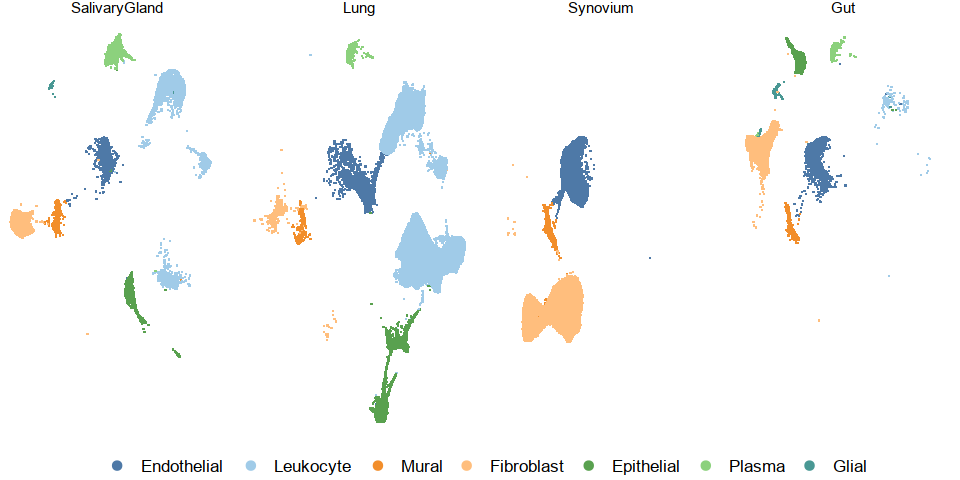

In [9]:
fig.size(4, 8)
p2 <- do_scatter(
    obj$umap_before, 
    obj$meta_data %>% 
        dplyr::mutate(Tissue = factor(Tissue, c('SalivaryGland', 'Lung', 'Synovium', 'Gut'))), 
    'Lineage', 
#     quo(Tissue), nrow = 1, 
    base_size = 14, pt_size = 4,
    palette_use = palette_global[unique(obj$meta_data$Lineage)], 
#     do_raster = TRUE, h = 3, w = 4,
    do_labels = FALSE, no_guides = FALSE
) + 
    facet_wrap(~Tissue, nrow = 1) + 
    theme_void() + 
    theme(
        legend.text = element_text(size = 10),
        legend.position = 'bottom',
        legend.title = element_blank(),
        legend.margin = margin(c(0, 0, 0, 0))
    ) + 
    guides(
        color = guide_legend(override.aes = list(stroke = 1, alpha = 1, shape = 16, size = 2), nrow = 1), 
        alpha = FALSE        
    ) + 
    scale_x_continuous(breaks = c(-5, 0, 5)) + 
    scale_y_continuous(breaks = c(-5, 0, 5))

p2


# Feature plots

## Ridge plots

In [10]:
genes_plot <- c('PTPRC', 'COL1A1', 'MCAM', 'CDH5', 'EPCAM', 'GFRA3', 'JCHAIN')
plt_df <- obj$meta_data %>% 
    cbind(t(scaleData(obj$exprs_norm[genes_plot, ]))) %>% 
    tidyr::gather(gene, value, PTPRC:JCHAIN) %>% 
    dplyr::mutate(value = pmin(value, 3)) %>% 
    dplyr::mutate(Tissue = factor(Tissue, c('SalivaryGland', 'Lung', 'Synovium', 'Gut'))) 

Picking joint bandwidth of 0.0889

Picking joint bandwidth of 0.0759

Picking joint bandwidth of 0.0593

Picking joint bandwidth of 0.0983



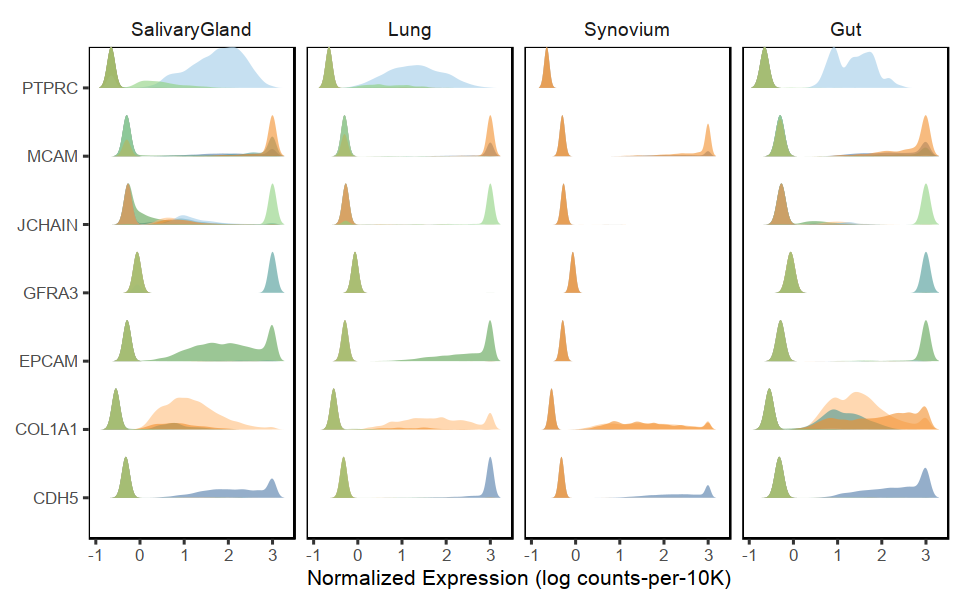

In [11]:
fig.size(5, 8)
p3 <- plt_df %>% 
    ggplot(aes(value, gene, fill = Lineage)) + 
        geom_density_ridges(aes(height = ..ndensity..), scale = .6, color = NA, alpha = .6) + 
#     ggplot(aes(value, gene, color = Lineage)) + 
#         geom_density_ridges(aes(height = ..ndensity..), scale = .6, fill = NA, alpha = .6) + 
        facet_grid(.~Tissue) + 
        scale_fill_manual(values = palette_global[unique(plt_df$Lineage)]) + 
        scale_color_manual(values = palette_global[unique(plt_df$Lineage)]) + 
        theme(
            axis.title.y = element_blank()
        ) + 
        guides(fill = 'none') + 
        labs(x = 'Normalized Expression (log counts-per-10K)') + 
        NULL

p3

## UMAPs (OLD)

In [12]:
# genes_plot <- c('PTPRC', 'COL1A1', 'MCAM', 'CDH5', 'EPCAM', 'GFRA3', 'JCHAIN')


# # fig.size(5, 8)
# fig.size(8, 5)
# p3 <- obj$umap_before %>% 
#     data.table() %>% 
#     cbind(obj$meta_data) %>% 
#     cbind(t(scaleData(obj$exprs_norm[genes_plot, ]))) %>% 
#     tidyr::gather(gene, value, PTPRC:JCHAIN) %>% 
#     dplyr::mutate(value = pmin(value, 3)) %>% 
#     dplyr::mutate(Tissue = factor(Tissue, c('SalivaryGland', 'Lung', 'Synovium', 'Gut'))) %>% 
#     ggplot(aes(V1, V2, z = value)) + 
#         stat_summary_hex(bins = 50) + 
#         facet_grid(gene ~ Tissue) + 
# #         facet_grid(Tissue ~ gene) + 
# #         facet_grid(gene ~ Tissue) + 
# #         scale_fill_gradient2_tableau() + 
#         scale_fill_gradient2(mid = 'lightgrey', low = 'white', high = muted('red'), midpoint = 0) + 
#         labs(x = 'UMAP 1', y = 'UMAP 2') + 
#         guides(fill = FALSE) + 
#         scale_x_continuous(breaks = c(-5, 0, 5)) + 
#         scale_y_continuous(breaks = c(-5, 0, 5)) + 
#         NULL

# p3


# Tissue-defined UMAPs

In [13]:
tissue_cluster_levels <- obj_fib$meta_data %>% 
    dplyr::select(tissue_cluster, Tissue) %>% 
    unique() %>% 
    dplyr::mutate(Tissue = factor(Tissue, c('SalivaryGland', 'Lung', 'Synovium', 'Gut'))) %>%  
    arrange(Tissue) %>% 
    with(tissue_cluster)

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


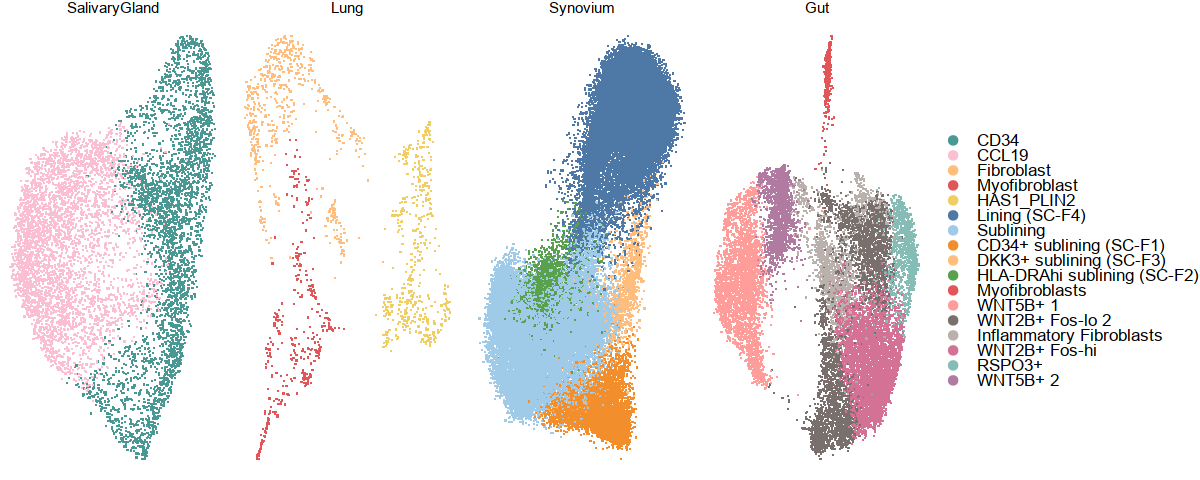

In [14]:
fig.size(4, 10)
# cbind(
#     bind_rows(map(fib, 'meta_data')),
#     bind_rows(map(map(fib, 'umap_after'), as.data.frame))
# ) %>% 
#     subset(!tissue_cell_type %in% c('UNKNOWN', 'DOUBLET', 'LOWQC')) %>% 
f1 <- do_scatter(
    dplyr::select(obj_fib$meta_data, X1 = UMAP1_tissue, X2 = UMAP2_tissue),
    obj_fib$meta_data %>% 
        dplyr::mutate(Tissue = factor(Tissue, c('SalivaryGland', 'Lung', 'Synovium', 'Gut'))) %>%  
        dplyr::mutate(tissue_cluster = factor(tissue_cluster, tissue_cluster_levels)), 
#             dplyr::mutate(.y, tissue_cell_type = gsub('Aviv_', '', tissue_cell_type)),
    'tissue_cluster',
    base_size = 10, 
    no_guides = FALSE, 
    do_labels = FALSE, 
    palette_use = palette_global[tissue_cluster_levels], 
#     do_raster = TRUE, w = 1.5, h = 2
) + 
#     facet_wrap(~Tissue, nrow = 1, scales = 'free') + 
#             theme_test(base_size = 14) + 
    guides(
        color = guide_legend(
#                 nrow = round(length(unique(.y$tissue_cell_type)) / 2), 
#                 byrow = TRUE, 
            override.aes = list(size = 2, stroke = 1, shape = 16)
        )
    ) + 
#             theme(legend.key.height = unit(.1, 'cm'), legend.key.size = unit(.3, "cm")) + 
    theme_void() + 
    theme(
#         legend.position = 'bottom', legend.title.align = 0,
        legend.key.height = unit(0, 'cm'),
#                 legend.key = element_blank(), 
#                 legend.box.background = element_rect(color="red", size=2),
        legend.text = element_text(size = 10)
    ) + 
    labs(fill = '', color = '') + 
    coord_cartesian(clip = 'off') + 
    facet_wrap(~Tissue, nrow = 1, scales = 'free') + 
    NULL

f1


# Tissue-defined heatmaps

In [15]:
effects <- fib %>% map('presto') %>% map('effects')

all_genes <- effects %>% 
    map('feature') %>% 
    map(unique) %>% 
    reduce(intersect)


effects_all <- effects %>% 
    map(dplyr::select, -pvalue) %>% ## old p-values were one-tailed 
    map(dplyr::mutate, pvalue = 2 * exp(pnorm(abs(zscore), log.p = TRUE, lower.tail = FALSE))) %>% 
    bind_rows(.id = 'Tissue') %>%
    subset(!Cluster %in% c('DOUBLET', 'LOWQC', 'UNKNOWN', 'NOTCH3+ perivascular')) %>% 
    subset(feature %in% all_genes) ## only keep genes in all datasets


In [16]:

# genes_shared <- data.table(effects_all)[beta > 0.5 & pvalue < .01, .SD[1], by = .(feature, Tissue)][, .N, by = feature][N > 1, feature]
# length(genes_shared)
genes_shared <- data.table(effects_all)[beta > 0.5 & pvalue < .01, unique(feature)]
length(genes_shared)

plt_mat <- effects_all %>% 
#     subset(Cluster %in% markers_all$Cluster) %>% 
    subset(feature %in% genes_shared) %>% 
    dplyr::select(feature, Cluster, Tissue, zscore) %>% 
    tidyr::unite(Tissue_Cluster, Tissue, Cluster) %>% 
    tidyr::spread(Tissue_Cluster, zscore) %>% 
    tibble::column_to_rownames('feature') %>% 
    t() %>% scale %>% t %>% cor()

dim(plt_mat)


# hr <- -plt_mat %>% as.dist %>% hclust %>% as.dendrogram()
set.seed(10)
# hr <- plt_mat %>% pmax(0) %>% t %>% scale %>% t %>% dist %>% hclust %>% as.dendrogram()
hr <- plt_mat %>% pmax(0) %>% dist %>% hclust %>% as.dendrogram()
# hr <- plt_mat %>% scale %>% dist %>% hclust %>% as.dendrogram()
# hr <- plt_mat %>% dist %>% hclust %>% as.dendrogram()
.x <- dendextend::cutree(hr, 5)
gene_clusters <- LETTERS[.x]
names(gene_clusters) <- names(.x)
# LETTERS[dendextend::cutree(hr, 8)]
table(gene_clusters)
head(gene_clusters)

[1] 2575

[1] 17 17

gene_clusters
A B C D E 
3 2 4 5 3 

gut_Inflammatory Fibroblasts           gut_Myofibroblasts 
                         "A"                          "B" 
                  gut_RSPO3+            gut_WNT2B+ Fos-hi 
                         "C"                          "C" 
         gut_WNT2B+ Fos-lo 2                 gut_WNT5B+ 1 
                         "D"                          "E"

In [17]:
shared_df <- effects_all %>% 
    dplyr::mutate(TERM = paste(Tissue, Cluster, sep = '_')) %>% 
    left_join(tibble::rownames_to_column(data.frame(gene_clusters), 'TERM'), by = 'TERM') %>% 
    split(.$gene_clusters) %>% 
    map(function(.SD) {
        data.table(.SD)[, .(V1 = sum(zscore > 1) / .N, zscore = mean(zscore)), by = feature][V1 == 1][, V1 := NULL][] %>% 
            arrange(-zscore) 
#         %>% 
#             head(50)
#         data.table(.SD)[, V1 := sum(zscore > 2) / .N, by = feature][V1 == 1][]
    }) %>% 
    bind_rows(.id = 'gene_clusters') %>% 
    left_join(tibble::rownames_to_column(data.frame(gene_clusters), 'TERM')) %>% 
    tidyr::separate(TERM, c('Tissue', 'Cluster'), extra = 'merge') %>% 
    left_join(effects_all)
#     left_join(dplyr::select(effects_all, feature, Tissue, Cluster, zscore, beta))
    
head(shared_df)

Joining, by = "gene_clusters"

Joining, by = c("feature", "zscore", "Tissue", "Cluster")



gene_clusters,feature,zscore,Tissue,Cluster,contrast,beta,sigma,pvalue
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
A,COL3A1,8.868478,gut,Inflammatory Fibroblasts,NA,NA,NA,NA
A,COL3A1,8.868478,lung,Myofibroblast,NA,NA,NA,NA
A,COL3A1,8.868478,synovium,DKK3+ sublining (SC-F3),NA,NA,NA,NA
A,COL1A1,8.649758,gut,Inflammatory Fibroblasts,NA,NA,NA,NA
A,COL1A1,8.649758,lung,Myofibroblast,NA,NA,NA,NA
A,COL1A1,8.649758,synovium,DKK3+ sublining (SC-F3),NA,NA,NA,NA


In [18]:
shared_df %>% split(.$gene_clusters) %>% map('feature') %>% map(unique) %>% map_int(length) %>% sort()

D   C   A   E   B 
 17 103 264 265 318

In [19]:
plt_mat <- effects_all %>% 
    subset(feature %in% shared_df$feature) %>% 
    dplyr::select(feature, Cluster, Tissue, zscore) %>% 
    tidyr::unite(Tissue_Cluster, Tissue, Cluster) %>% 
    tidyr::spread(Tissue_Cluster, zscore) %>% 
    tibble::column_to_rownames('feature') %>% 
    t()

dim(plt_mat)


[1]  17 894

In [20]:
genes_ccl <- shared_df %>% dplyr::select(gene_clusters, feature, zscore) %>% unique() %>% 
    split(.$gene_clusters) %>% 
    map(arrange, -zscore) %>% 
    map(head, 5) %>% 
    map('feature') %>% 
    reduce(union)

# shared_df %>% dplyr::select(gene_clusters, feature, zscore) %>% unique() %>% 
#     split(.$gene_clusters) %>% 
#     map(arrange, -zscore) %>% 
#     map(head, 5)

In [21]:
fig.size(5, 10)
ht_opt(RESET = TRUE)
ht_opt("heatmap_column_names_gp" = gpar(fontsize = 6))
ht_opt("heatmap_row_names_gp" = gpar(fontsize = 10))
ccl <- colnames(plt_mat) %in% genes_ccl

h1 <- Heatmap(
    matrix = plt_mat,
    row_labels = gsub('^(.*?)_(.*)', '\\2', rownames(plt_mat)), 
    column_title_side = 'bottom',
    column_title_gp = gpar(fontsize = 8, fontface = "bold"),
    
    show_column_dend = FALSE,     
    name = 'z-score', 
    show_column_names = FALSE,
    colorRamp2(c(-3, 0, 3), c('white', 'white', muted('blue'))),    
    column_names_rot = 90, 
#     use_raster = TRUE, raster_device = "CairoJPEG",

    cluster_columns = TRUE, 
    row_split = gene_clusters, 
    cluster_rows = TRUE,  ## AUTO
    show_heatmap_legend = TRUE, 
    heatmap_legend_param = list(
        legend_direction = "horizontal",
        title_position = 'lefttop',
        legend_height = unit(2, "cm")
    ),
    right_annotation = rowAnnotation(
        df = data.frame(
            Tissue = gsub('^(.*?)_(.*)', '\\1', rownames(plt_mat))
        ),
        show_legend = FALSE, 
        show_annotation_name = FALSE,
        col = palette_heatmap
    ),
    top_annotation = columnAnnotation(
        show_legend = FALSE, 
        show_annotation_name = FALSE,
        link = anno_mark(
            at = which(ccl), 
            labels = colnames(plt_mat)[ccl], 
            labels_gp = gpar(fontsize = 10), padding = unit(.5, "mm"),
            labels_rot = 75
        ),
        col = palette_heatmap
    ),
)

# draw(h1, heatmap_legend_side = 'bottom')

# f2 <- grid.grabExpr(draw(h1, heatmap_legend_side = 'bottom'))
f2 <- grid.grabExpr(draw(h1, padding = unit(c(10, 2, 2, 2), "mm"), heatmap_legend_side = 'bottom')) #bottom, left, top, right paddings



# Cartoon

In [22]:
library(png)
g0 <- readPNG('/data/srlab2/ik936/Roche/manuscript/figures/cartoon_figure1_design.png', native = TRUE) %>% 
    rasterGrob(interpolate = TRUE)

# fig.size(8, 12)
# wrap_elements(g0)

# Panels

Picking joint bandwidth of 0.0889

Picking joint bandwidth of 0.0759

Picking joint bandwidth of 0.0593

Picking joint bandwidth of 0.0983



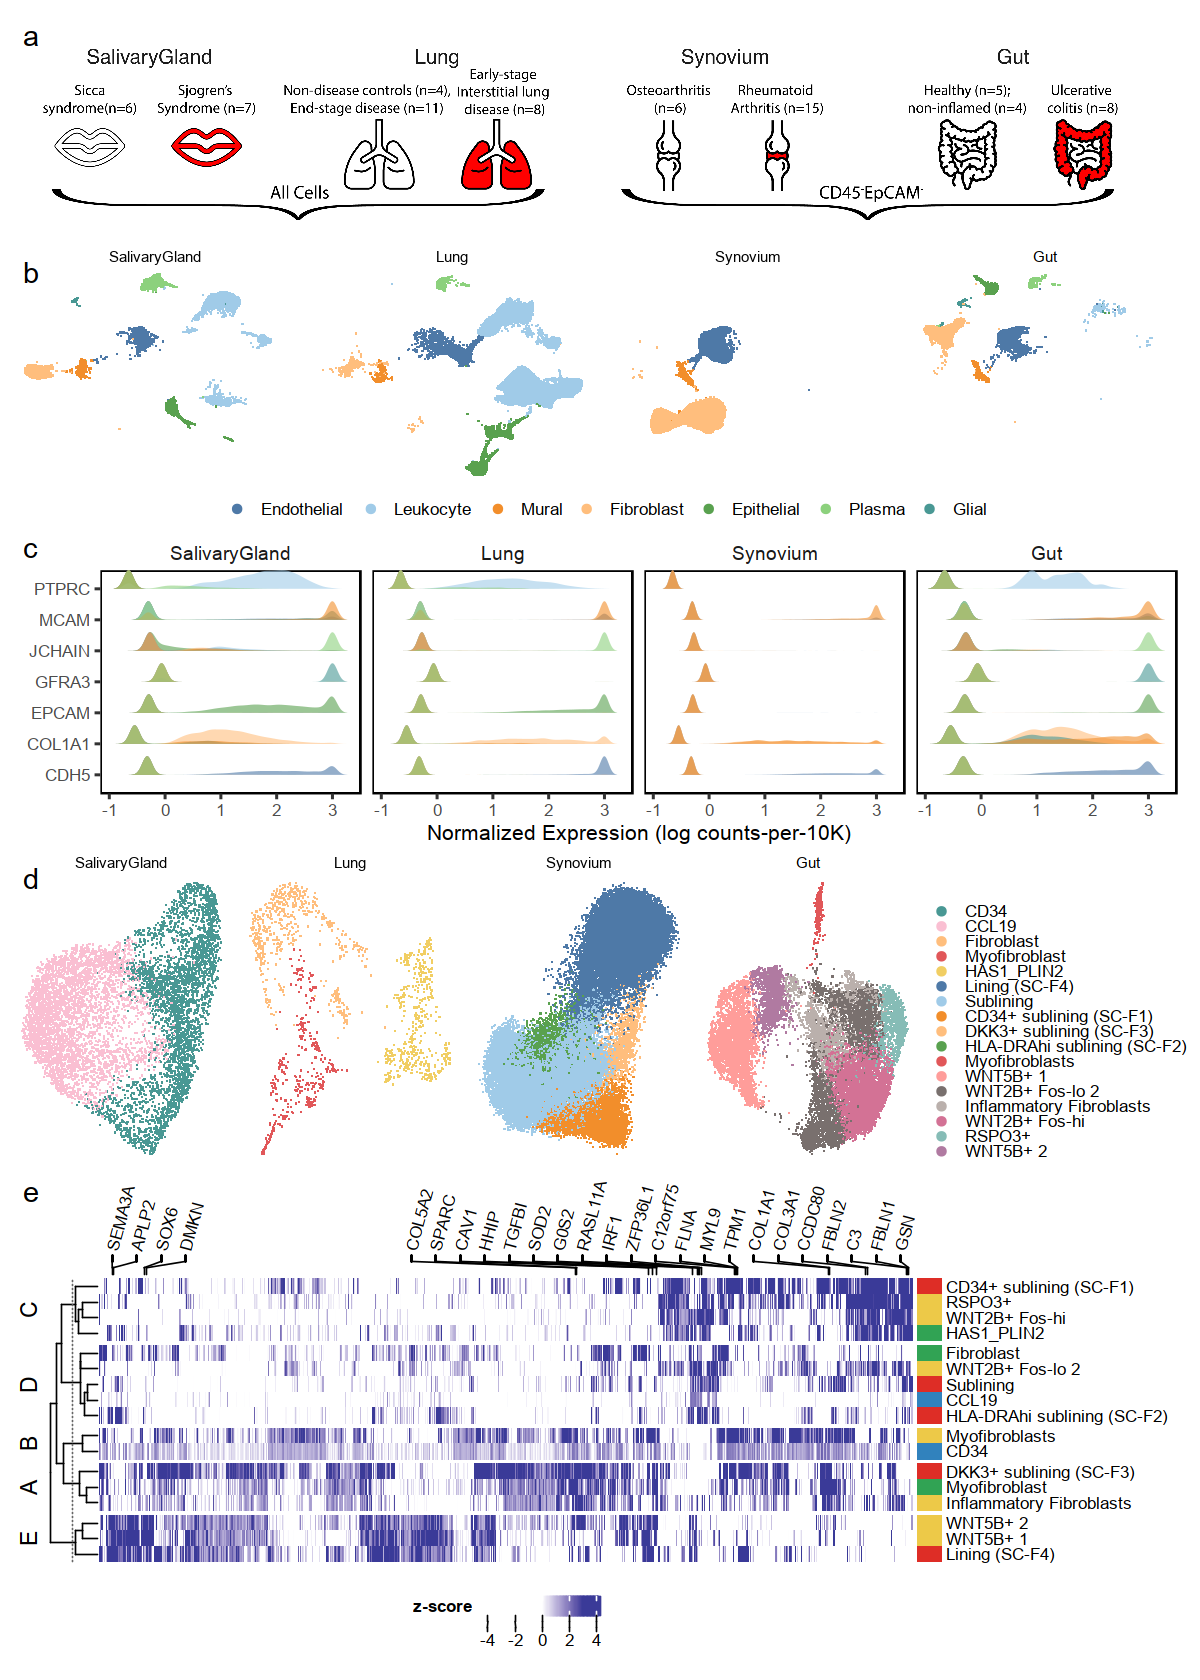

In [23]:
fig <- (
    (
#         wrap_elements(grid::textGrob('Cartoon')) 
        wrap_elements(full = g0)
    ) / 
    (
        wrap_elements(full = p2) 
    ) / 
    (
        wrap_elements(full = p3)
    ) / 
    (
        wrap_elements(full = f1)
    ) /
    (
        wrap_elements(full = f2)
    ) 
) + 
    plot_layout(heights = c(.5, .6, .75, .7, 1.2)) + 
    plot_annotation(tag_levels = 'a')

fig.size(14, 10)
fig

In [24]:
ggsave(
    filename = '/data/srlab2/ik936/Roche/manuscript/figures/Figure1.pdf', 
    plot = fig,
    units = 'in', device = 'pdf', 
    height = 14, width = 10,
    useDingbats = FALSE
)



Picking joint bandwidth of 0.0889

Picking joint bandwidth of 0.0759

Picking joint bandwidth of 0.0593

Picking joint bandwidth of 0.0983

